# 3. Synthesis Planning Using SynPlanner

* [SynPlanner](https://github.com/Laboratoire-de-Chemoinformatique/SynPlanner/blob/main/tutorials/SynPlanner_Pipeline.ipynb) is an open-source retrosynthesis planner and includes the original modules for reaction data curation, reaction rules extraction, retrosynthetic models training, and retrosynthesis planning. SynPlanner is based on the open-source Python 3 packages for reaction chemoinformatics and deep learning frameworks.

* The retrosynthetic planning in SynPlanner is performed by ***Monte Carlo Tree Search (MCTS)*** guided by graph neural networks for node expansion (retrosynthetic rule predictions) and evaluation (precursor synthesizability prediction).

**Best GPU Choice for SynPlanner in Colab**

* SynPlanner’s Monte-Carlo Tree Search (MCTS) and GNN inference are currently PyTorch-based and optimized for GPU.

* When running SynPlanner’s MCTS in Colab, GPU inference speed is the key driver of overall runtime. Based on the last run on a T4 (66.6 s for 300 iterations, ~4 300 nodes, 234 routes), here’s how each option stacks up:

* **CPU only:**
RDKit expansions + Python overhead • Typically 8–10× slower than T4.

* **T4 (free tiers):** 8.1 TFLOPS FP32, 65 TFLOPS FP16, 16 GB VRAM • Baseline: your current 66.6 s runtime.

* **V100 (Pro):** 14 TFLOPS FP32, 112 TFLOPS FP16, 16 GB VRAM • ~1.7× FP32 and ~1.7× FP16 speedup vs. T4.

* **A100 (Pro+ High-RAM):** 19.5 TFLOPS FP32, 312 TFLOPS FP16, 40 GB VRAM • ~2.4× FP32 and ~4.8× FP16 speedup vs. T4.



* Overall, The T4 GPU will be perfectly fine for our uses here.


In [13]:
#@title SynPlanner Installation
%%bash
git clone https://github.com/Laboratoire-de-Chemoinformatique/SynPlanner.git
cd SynPlanner/
pip install -q .

fatal: destination path 'SynPlanner' already exists and is not an empty directory.


In [14]:
#@title 1. Set up input and output data locations
import os
import pickle
import shutil
from pathlib import Path
from synplan.utils.loading import download_all_data

# download SynPlanner data
data_folder = Path("synplan_data").resolve()
download_all_data(save_to=data_folder)

# input data
# You can use the input data:
# 1. Curated USPTO data, extracted reaction rules, pretrained policy network and building blocks from downloaded data
# 2. Use curated USPTO data, extracted reaction rules, pretrained policy network prepared with tutorials

USE_DOWNLOAD_DATA = True # is False if you want to use the data and models from previous tutorial steps
if USE_DOWNLOAD_DATA:
    # input data
    ranking_policy_network = data_folder.joinpath("uspto/weights/ranking_policy_network.ckpt").resolve(strict=True)
    reaction_rules_path = data_folder.joinpath("uspto/uspto_reaction_rules.pickle")
    # planning reslts folder
    results_folder = Path("planning_with_downloaded_data").resolve()
    results_folder.mkdir(exist_ok=True)
else:
    # input data
    tutorial_results_folder = Path("tutorial_results").resolve()
    ranking_policy_network = tutorial_results_folder.joinpath("ranking_policy_network/policy_network.ckpt").resolve(strict=True)
    reaction_rules_path = tutorial_results_folder.joinpath("uspto_reaction_rules.pickle")
    # planning reslts folder
    results_folder = Path("planning_with_tutorial_data").resolve()
    results_folder.mkdir(exist_ok=True)

# use your custom building blocks if needed
building_blocks_path = data_folder.joinpath("building_blocks/building_blocks_em_sa_ln.smi")

Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

Support for third party widgets will remain active for the duration of the session. To disable support:

In [3]:
from google.colab import output
output.disable_custom_widget_manager()

In [4]:
#@title Loading building blocks
from synplan.utils.loading import load_building_blocks

building_blocks = load_building_blocks(building_blocks_path, standardize=False)

In [5]:
#@title Loading reaction rules
from synplan.utils.loading import load_reaction_rules

reaction_rules = load_reaction_rules(reaction_rules_path)

In [6]:
#@title Loading policy network
from synplan.mcts.expansion import PolicyNetworkFunction
from synplan.utils.config import PolicyNetworkConfig

policy_config = PolicyNetworkConfig(weights_path=ranking_policy_network)
policy_network = PolicyNetworkFunction(policy_config=policy_config)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint synplan_data/uspto/weights/ranking_policy_network.ckpt`


In [15]:
#@title Configure the Monte-Carlo Tree Search
from synplan.utils.config import TreeConfig

tree_config = TreeConfig(
    search_strategy="expansion_first",
    evaluation_type="rollout",
    max_iterations=300,
    max_time=120,
    max_depth=9,
    min_mol_size=1,
    init_node_value=0.5,
    ucb_type="uct",
    c_ucb=0.1,
)

In [16]:
#@title Colab: 2D molecule sketcher + "Save 2D structure as SMILES"
from IPython.display import HTML, display
#Javascript
html = r"""
<div id="mol-sketcher-root" style="font-family:system-ui,-apple-system,Segoe UI,Roboto,Inter,Helvetica,Arial,sans-serif; line-height:1.35;">
  <h3 style="margin:0 0 8px;">2D Molecular Sketcher</h3>
  <div id="status" style="font-size:12px;color:#666;margin:0 0 8px;">Loading editor…</div>

  <!-- Editor goes here -->
  <div id="jsme_container" style="width:720px;height:480px;border:1px solid #e3e3e3;border-radius:8px;overflow:hidden;"></div>

  <div style="margin-top:10px; display:flex; gap:8px; align-items:center; flex-wrap:wrap;">
    <button id="saveBtn" style="padding:8px 12px;border:1px solid #ccc;border-radius:8px;background:#fafafa;cursor:pointer;">
      Save 2D structure as SMILES
    </button>
    <span id="savedBadge" style="display:none;font-size:12px;color:#2e7d32;">Saved ✓</span>
  </div>

  <div style="margin-top:10px;">
    <div style="font-size:12px;color:#444;margin-bottom:4px;">SMILES</div>
    <pre id="smiles_output" style="min-height:1.6em;padding:8px;border:1px dashed #d0d0d0;border-radius:8px;background:#fcfcfc;white-space:pre-wrap;word-break:break-word;margin:0;"></pre>
  </div>
</div>

<script>
// -------------- Configuration (optional) ----------------
// You can pre-load a structure by putting a SMILES here, e.g. "CC(=O)Oc1ccccc1C(=O)O"
const INITIAL_SMILES = "";

// -------------- JSME loader with fallback CDNs ----------
(function() {
  // Define jsmeOnLoad **before** loading the script — JSME will call this automatically.
  window.jsmeOnLoad = function() {
    const status = document.getElementById('status');
    try {
      // Make editor width responsive-ish based on the output area.
      const hostWidth = Math.max(520, Math.min(860, document.getElementById('mol-sketcher-root').clientWidth || 720));
      const widthPx  = hostWidth + "px";
      const heightPx = "480px";

      // Options: stereo & auto E/Z, show implicit H on heteroatoms, allow zoom, modern UI.
      const opts = { "options": "newlook,stereo,autoez,hydrogens,zoom" };

      // Create the editor
      window.jsmeApplet = new JSApplet.JSME("jsme_container", widthPx, heightPx, opts);

      // Optionally load an initial molecule
      if (INITIAL_SMILES && typeof INITIAL_SMILES === "string") {
        try { window.jsmeApplet.readGenericMolecularInput(INITIAL_SMILES); } catch(e) {}
      }

      // Wire up the Save button
      const saveBtn = document.getElementById("saveBtn");
      const out = document.getElementById("smiles_output");
      const badge = document.getElementById("savedBadge");

      saveBtn.addEventListener("click", () => {
        try {
          const smiles = window.jsmeApplet.smiles() || "";
          out.textContent = smiles;
          // Tiny “saved” tick feedback
          badge.style.display = "inline";
          setTimeout(() => { badge.style.display = "none"; }, 1200);
        } catch(err) {
          out.textContent = "[Error reading SMILES: " + (err && err.message ? err.message : err) + "]";
        }
      });

      status.textContent = "Editor ready. Draw your molecule, then click “Save 2D structure as SMILES”.";
      status.style.color = "#2e7d32";
    } catch (e) {
      status.textContent = "Editor failed to initialize: " + e;
      status.style.color = "#b00020";
    }
  };

  // Load JSME from a stable source, with two fallbacks.
  const sources = [
    "https://jsme-editor.github.io/dist/jsme/jsme.nocache.js",
    "https://cdn.jsdelivr.net/npm/jsme-editor@2024.4.29/dist/jsme/jsme.nocache.js",
    "https://unpkg.com/jsme-editor@2024.4.29/dist/jsme/jsme.nocache.js"
  ];
  const status = document.getElementById('status');

  function loadScript(i) {
    if (i >= sources.length) {
      status.textContent = "Could not load the JSME script from any source.";
      status.style.color = "#b00020";
      return;
    }
    const s = document.createElement("script");
    s.type = "text/javascript";
    s.src = sources[i];
    s.onload = function() { /* JSME will call window.jsmeOnLoad() on its own. */ };
    s.onerror = function() { loadScript(i + 1); };
    document.head.appendChild(s);
    status.textContent = "Loading editor… (" + sources[i] + ")";
  }
  loadScript(0);
})();
</script>
"""

display(HTML(html))


In [17]:
#@title Loading the target molecule
from synplan.chem.utils import mol_from_smiles
#input your SMILES here:
example_smiles = "Cc3cc(N2C[C@@H](CO)[C@H](c1cccc(F)c1)C2)c(C#N)cn3"

target_molecule = mol_from_smiles(example_smiles, clean2d=True, standardize=True, clean_stereo=True)

In [18]:
#@title Initialising the tree
from synplan.mcts.tree import Tree

tree = Tree(
    target=target_molecule,
    config=tree_config,
    reaction_rules=reaction_rules,
    building_blocks=building_blocks,
    expansion_function=policy_network,
    # you can also specify evaluation_function=ValueNetwork(...), by default it is None
)

In [19]:
#@title Running retrosynthetic planning
tree_solved = False
for solved, node_id in tree:
    if solved:
        tree_solved = True
tree

  0%|          | 0/300 [00:00<?, ?it/s]

Tree for: OCC1C(c2cccc(c2)F)CN(c3c(C#N)cnc(c3)C)C1
Time: 70.0 seconds
Number of nodes: 4980
Number of iterations: 300
Number of visited nodes: 300
Number of found routes: 185

In [20]:
from google.colab import output
output.enable_custom_widget_manager()

In [66]:
#@title Retrosynthetic route visualisation (scrollable)
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from synplan.utils.visualisation import get_route_svg

# precompute scores once
node_scores = {nid: tree.route_score(nid) for nid in tree.winning_nodes}
sorted_nodes = sorted(node_scores, key=node_scores.get, reverse=True)

# create a bounded integer textbox
topk_txt = widgets.BoundedIntText(
    value=5,
    min=1,
    max=len(sorted_nodes),
    step=1,
    description='Show top K:',
    layout=widgets.Layout(width='200px')
)

def _on_topk_change(change):
    if change['name']=='value' and change['type']=='change':
        k = change['new']
        clear_output(wait=True)
        display(topk_txt)
        # visualize the top-k routes
        for idx, node_id in enumerate(sorted_nodes[:k], start=1):
            score = node_scores[node_id]
            display(HTML(f"<h4>Route #{idx} (node {node_id}) — score={score:.3f}</h4>"))
            svg = get_route_svg(tree, node_id)
            display(HTML(f"<div style='background:white;padding:8px'>{svg}</div>"))

# wire up the callback
topk_txt.observe(_on_topk_change)
# display widget and initial output
display(topk_txt)
_on_topk_change({'name':'value','new':topk_txt.value,'type':'change'})


BoundedIntText(value=11, description='Show top K:', layout=Layout(width='200px'), max=144, min=1)

In [62]:
#@title look for dictionaries in tree
attrs = [a for a in dir(tree) if not a.startswith("_")]
print(attrs)

for k,v in tree.__dict__.items():
    if isinstance(v, dict):
        print(f"{k}: dict with {len(v)} entries")


['building_blocks', 'children', 'config', 'curr_iteration', 'curr_time', 'curr_tree_size', 'expanded_nodes', 'newickify', 'nodes', 'nodes_depth', 'nodes_init_value', 'nodes_prob', 'nodes_rules', 'nodes_total_value', 'nodes_visit', 'parents', 'policy_network', 'reaction_rules', 'report', 'route_score', 'route_to_node', 'start_time', 'synthesis_route', 'visited_nodes', 'winning_nodes']
nodes: dict with 4980 entries
parents: dict with 4980 entries
children: dict with 4980 entries
nodes_visit: dict with 4980 entries
nodes_depth: dict with 4980 entries
nodes_prob: dict with 4980 entries
nodes_rules: dict with 4979 entries
nodes_init_value: dict with 4980 entries
nodes_total_value: dict with 4980 entries


In [63]:
#@title change the leaf_id (node) to the node of interest
# use the function from cell _Zxa0E5CqmiY to get the molecules in the route
# from _Zxa0E5CqmiY import get_full_route_smiles # this would be needed if the function was not in the same notebook
# Assuming the function get_full_route_smiles is defined in the current notebook:

leaf_id = 1979 #change leaf_id to the node of interest
# You might need to define target_smiles and root_id based on your desired route
# For example:
target_smiles = "Cc3cc(N2C[C@@H](CO)[C@H](c1cccc(F)c1)C2)c(C#N)cn3" # Use the same target smiles as used for building the tree
# You can find potential root_id values by inspecting the tree structure or the debug output of get_full_route_smiles if it raises an error
root_id = 1 # Replace with the correct root_id for the desired route

bbs = get_full_route_smiles(tree, leaf_id, target_smiles, root_id=root_id, dedupe=True)


print(f"Route #7 (node {leaf_id}) → {len(bbs)} building blocks:")
for smi in bbs:
    print("   ", smi)

Route #7 (node 1979) → 7 building blocks:
    Cc3cc(N2C[C@@H](CO)[C@H](c1cccc(F)c1)C2)c(C#N)cn3
    c1cc(ccc1)CN2CC(CO)C(c3cc(F)ccc3)C2
    O=Cc1c(cc(nc1)C)Br
    [NH4+]
    c1(cc(ncc1C#N)C)Br
    OCC1C(c2cccc(c2)F)CNC1
    OCC1C(c2cccc(c2)F)CN(c3c(C#N)cnc(c3)C)C1


In [59]:
!pip install rdkit

Collected 7 SMILES (raw):
   1: OCC1C(c2cccc(c2)F)CNC1
   2: c1cc(ccc1)CN2CC(CO)C(c3cc(F)ccc3)C2
   3: O=Cc1c(cc(nc1)C)Br
   4: [NH4+]
   5: c1(cc(ncc1C#N)C)Br
   6: OCC1C(c2cccc(c2)F)CNC1
   7: OCC1C(c2cccc(c2)F)CN(c3c(C#N)cnc(c3)C)C1

After dedupe: 6 unique SMILES:
   1: OCC1C(c2cccc(c2)F)CNC1
   2: c1cc(ccc1)CN2CC(CO)C(c3cc(F)ccc3)C2
   3: O=Cc1c(cc(nc1)C)Br
   4: [NH4+]
   5: c1(cc(ncc1C#N)C)Br
   6: OCC1C(c2cccc(c2)F)CN(c3c(C#N)cnc(c3)C)C1


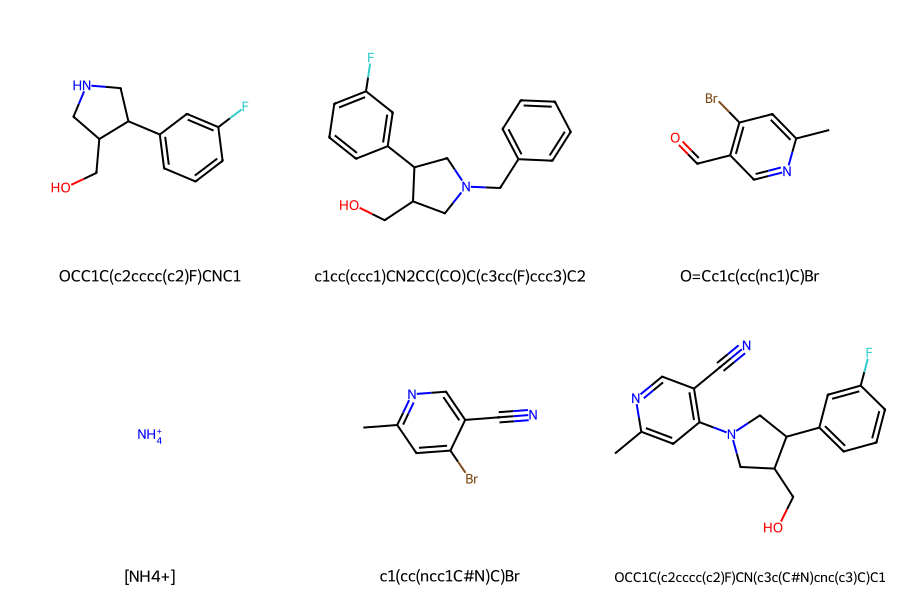

In [64]:
#@title Show the unique reagents in the retrosynthesis tree
from rdkit import Chem
from rdkit.Chem import MolToSmiles, AllChem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display


def _precursor_smi(p):
    """Convert a precursor object (or SMILES string) into a SMILES string."""
    if isinstance(p, str):
        return p
    if hasattr(p, "smiles"):
        return p.smiles
    try:
        return MolToSmiles(p)
    except:
        return repr(p)


def _detect_roots(tree):
    """
    Return a list of candidate root IDs via three strategies:
      1) Parent is explicitly None.
      2) Parent equals the node itself.
      3) Node IDs that never appear as a child key.
    """
    # 1) explicit None parents
    none_parents   = [n for n, p in tree.parents.items() if p is None]
    # 2) self‐parent nodes
    self_parents   = [n for n, p in tree.parents.items() if n == p]
    # 3) nodes that never appear as a child
    node_ids       = set(tree.nodes.keys())
    child_keys     = set(tree.parents.keys())
    diff_parents   = list(node_ids - child_keys)

    # combine all candidates uniquely
    candidates = []
    for lst in (none_parents, self_parents, diff_parents):
        for r in lst:
            if r not in candidates:
                candidates.append(r)
    return candidates


def get_full_route_smiles(
    tree,
    leaf_id,
    target_smiles,
    root_id=None,
    dedupe=True
):
    """
    Walk from leaf → root, collecting each node’s new_precursors as SMILES.

    Args:
      tree           : SynPlanner MCTS tree
      leaf_id        : ID of the leaf node (e.g. 1979)
      target_smiles  : SMILES of the final product
      root_id        : optionally force a specific root node ID
      dedupe         : if True, collapse duplicates at the end

    Returns:
      List of SMILES: [target, BB_step1, BB_step2, …]
    """
    # 1) Auto-detect or validate root_id
    if root_id is None:
        candidates = _detect_roots(tree)
        if not candidates:
            print("DEBUG: All node IDs  =", set(tree.nodes.keys()))
            print("DEBUG: Child keys   =", set(tree.parents.keys()))
            raise ValueError(
                "No root candidates found. "
                "Please inspect the debug output or set `root_id` manually."
            )
        if len(candidates) > 1:
            print("DEBUG: Root candidates =", candidates)
            raise ValueError(
                f"Multiple root candidates found: {candidates}. "
                "Please choose the correct `root_id` under USER INPUTS."
            )
        root_id = candidates[0]

    # 2) Traverse leaf → root, gathering SMILES
    all_smis = [target_smiles]
    cur      = leaf_id

    while True:
        parent = tree.parents.get(cur)
        if parent is None or parent not in tree.nodes:
            break

        # collect this step’s precursors
        for p in tree.nodes[parent].new_precursors:
            all_smis.append(_precursor_smi(p))

        # stop after collecting the root’s precursors
        if parent == root_id:
            break

        cur = parent

    # 3) Dedupe if requested
    if dedupe:
        seen, uniq = set(), []
        for smi in all_smis:
            if smi not in seen:
                seen.add(smi)
                uniq.append(smi)
        return uniq

    return all_smis


if __name__ == "__main__":
    # ==== USER INPUTS ====
    leaf_id       = 1979
    target_smiles = "OCC1C(c2cccc(c2)F)CNC1"
    # After running once, inspect debug output and uncomment below:
    root_id     = 15

    # 1) Raw SMILES (with duplicates)
    raw_smis = get_full_route_smiles(
        tree,
        leaf_id,
        target_smiles,
        root_id=root_id,
        dedupe=False
    )
    print(f"Collected {len(raw_smis)} SMILES (raw):")
    for i, smi in enumerate(raw_smis, 1):
        print(f"  {i:>2}: {smi}")

    # 2) Unique SMILES (deduped)
    uniq_smis = get_full_route_smiles(
        tree,
        leaf_id,
        target_smiles,
        root_id=root_id,
        dedupe=True
    )
    print(f"\nAfter dedupe: {len(uniq_smis)} unique SMILES:")
    for i, smi in enumerate(uniq_smis, 1):
        print(f"  {i:>2}: {smi}")

    # 3) (Optional) Visualize in 2D grid
    mols = []
    for smi in uniq_smis:
        m = Chem.MolFromSmiles(smi)
        AllChem.Compute2DCoords(m)
        mols.append(m)

    img = MolsToGridImage(
        mols,
        legends=uniq_smis,
        molsPerRow=3,
        subImgSize=(300, 300),
        useSVG=True
    )
    display(img)


In [95]:
#@title List the precursors for each step
# 1) helper to extract SMILES from any object
from rdkit.Chem import MolToSmiles
def _precursor_smi(p):
    if isinstance(p, str):
        return p
    if hasattr(p, "smiles"):
        return p.smiles
    try:
        return MolToSmiles(p)
    except:
        return repr(p)

# 2) new helper to grab reagents *and* precursors for one disconnection
def get_step_chems(tree, node_id):
    """
    Returns two lists for a given disconnection step:
      - precursors: the molecular fragments you must make (new_precursors)
      - reagents:   the "extra" chemicals used (e.g. NCS)
    """
    parent = tree.parents[node_id]
    node   = tree.nodes[parent]

    # your usual building blocks:
    bb = [_precursor_smi(p) for p in node.new_precursors]

    # now the reagents: this lives in the node’s reaction metadata or applied rule
    # **options depend on your SynPlanner version**, but typically:
    #  • node.applied_rule.reagents
    #  • node.reaction_metadata["reagents"]
    #  • node.rule_metadata["reagents_smiles"]

    reagents = []
    if hasattr(node, "applied_rule") and hasattr(node.applied_rule, "reagents"):
        reagents = [_precursor_smi(r) for r in node.applied_rule.reagents]
    elif hasattr(node, "reaction_metadata"):
        reagents = [
            _precursor_smi(r)
            for r in node.reaction_metadata.get("reagents", [])
        ]

    return bb, reagents

# 3) walk the route and collect *all* SMILES
leaf_id = 1979
cur     = leaf_id
all_chems = []
while True:
    parent = tree.parents.get(cur)
    if parent is None or parent not in tree.nodes:
        break

    bb, reag = get_step_chems(tree, cur)
    # record them in order (you can also dedupe later)
    all_chems.append({
        "step_node": parent,
        "precursors": bb,
        "reagents": reag
    })

    # stop once you hit your root (set root_id explicitly if needed)
    # if parent == root_id: break

    cur = parent

# 4) inspect what you collected
for i, step in enumerate(reversed(all_chems), 1):
    print(f"\nStep {i}: node {step['step_node']}")
    print("  precursors:", step["precursors"])
    print("  reagents:  ", step["reagents"])



Step 1: node 1
  precursors: ['OCC1C(c2cccc(c2)F)CN(c3c(C#N)cnc(c3)C)C1']
  reagents:   []

Step 2: node 7
  precursors: ['c1(cc(ncc1C#N)C)Br', 'OCC1C(c2cccc(c2)F)CNC1']
  reagents:   []

Step 3: node 194
  precursors: ['O=Cc1c(cc(nc1)C)Br', '[NH4+]']
  reagents:   []

Step 4: node 1931
  precursors: ['c1cc(ccc1)CN2CC(CO)C(c3cc(F)ccc3)C2']
  reagents:   []
